# Image Stitching Using SIFT Based Approach 

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from numpy.linalg import det, lstsq, norm
from numpy import all, any, array, arctan2, cos, sin, exp, dot, log, logical_and, roll, sqrt, stack, trace, unravel_index, pi, deg2rad, rad2deg, where, zeros, floor, full, nan, isnan, round, float32
from cv2 import resize, GaussianBlur, subtract, KeyPoint, INTER_LINEAR, INTER_NEAREST
from math import log, sqrt
from math import atan2, radians, degrees
from itertools import product
from collections import OrderedDict
from functools import cmp_to_key
from skimage.metrics import structural_similarity as ssim

# SIFT Algorithm 

In [2]:
def generate_images(image, sigma, assumed_blur, num_intervals):
    """Generate Difference-of-Gaussians (DoG) image pyramid, Gaussian image pyramid, Gaussian kernels, number of octaves, and base image."""

    # Generate base image from input image by upsampling by 2 in both directions and blurring
    image = cv2.resize(image, (0, 0), fx=2, fy=2, interpolation=cv2.INTER_LINEAR)
    sigma_diff = sqrt(max((sigma ** 2) - ((2 * assumed_blur) ** 2), 0.01))
    base_image = cv2.GaussianBlur(image, (0, 0), sigmaX=sigma_diff, sigmaY=sigma_diff)

    # Compute number of octaves in image pyramid as function of base image shape (OpenCV default)
    num_octaves = int(round(log(min(base_image.shape)) / log(2) - 1))

    # Generate list of gaussian kernels at which to blur the input image
    num_images_per_octave = num_intervals + 3
    k = 2 ** (1. / num_intervals)
    gaussian_kernels = np.zeros(num_images_per_octave)
    gaussian_kernels[0] = sigma
    for image_index in range(1, num_images_per_octave):
        sigma_previous = (k ** (image_index - 1)) * sigma
        sigma_total = k * sigma_previous
        gaussian_kernels[image_index] = sqrt(sigma_total ** 2 - sigma_previous ** 2)

    # Generate scale-space pyramid of Gaussian images
    gaussian_images = []
    for octave_index in range(num_octaves):
        gaussian_images_in_octave = [base_image]
        for gaussian_kernel in gaussian_kernels[1:]:
            base_image = cv2.GaussianBlur(base_image, (0, 0), sigmaX=gaussian_kernel, sigmaY=gaussian_kernel)
            gaussian_images_in_octave.append(base_image)
        gaussian_images.append(gaussian_images_in_octave)
        base_image = cv2.resize(gaussian_images_in_octave[-3], (gaussian_images_in_octave[-3].shape[1] // 2, gaussian_images_in_octave[-3].shape[0] // 2), interpolation=cv2.INTER_NEAREST)

    # Generate Difference-of-Gaussians image pyramid
    dog_images = []
    for gaussian_images_in_octave in gaussian_images:
        dog_images_in_octave = [np.subtract(second_image, first_image, dtype=np.float32) for first_image, second_image in zip(gaussian_images_in_octave, gaussian_images_in_octave[1:])]
        dog_images.append(dog_images_in_octave)

    return dog_images, gaussian_images


def compute_gradient_magnitude_and_orientation(gaussian_image, region_x, region_y):
    """Calculate gradient magnitude and orientation for the specified pixel."""
    dx = gaussian_image[region_y, region_x + 1] - gaussian_image[region_y, region_x - 1]
    dy = gaussian_image[region_y - 1, region_x] - gaussian_image[region_y + 1, region_x]
    magnitude = sqrt(dx**2 + dy**2)
    orientation = degrees(atan2(dy, dx)) % 360
    return magnitude, orientation

def smooth_histogram_fun(raw_histogram, num_bins):
    """Smooth the histogram using a weighted average."""
    return [(6 * raw_histogram[n] + 4 * (raw_histogram[n - 1] + raw_histogram[(n + 1) % num_bins]) +
             raw_histogram[n - 2] + raw_histogram[(n + 2) % num_bins]) / 16 for n in range(num_bins)]

def computeKeypointsWithOrientations(keypoint, octave_index, gaussian_image, radius_factor=3, num_bins=36, peak_ratio=0.8, scale_factor=1.5):
    """Compute orientations for each keypoint using gradient histograms."""
    scale = scale_factor * keypoint.size / float32(2 ** (octave_index + 1))
    radius = int(round(radius_factor * scale))
    weight_factor = -0.5 / (scale ** 2)
    raw_histogram = zeros(num_bins)
    image_shape = gaussian_image.shape

    # Calculate gradients and contribute to histogram
    for i in range(-radius, radius + 1):
        for j in range(-radius, radius + 1):
            region_y = int(round(keypoint.pt[1] / float32(2 ** octave_index))) + i
            region_x = int(round(keypoint.pt[0] / float32(2 ** octave_index))) + j
            if 0 < region_x < image_shape[1] - 1 and 0 < region_y < image_shape[0] - 1:
                magnitude, orientation = compute_gradient_magnitude_and_orientation(gaussian_image, region_x, region_y)
                bin_index = int(round(orientation * num_bins / 360.)) % num_bins
                raw_histogram[bin_index] += exp(weight_factor * (i**2 + j**2)) * magnitude

    # Smooth the histogram and find orientation peaks
    smooth_histogram = smooth_histogram_fun(raw_histogram, num_bins)
    orientation_max = max(smooth_histogram)
    keypoints_with_orientations = []
    for peak_index in [n for n in range(num_bins) if smooth_histogram[n] > max(smooth_histogram[n - 1], smooth_histogram[(n + 1) % num_bins]) and smooth_histogram[n] >= peak_ratio * orientation_max]:
        left, right = smooth_histogram[peak_index - 1], smooth_histogram[(peak_index + 1) % num_bins]
        interpolated_index = (peak_index + 0.5 * (left - right) / (left - 2 * smooth_histogram[peak_index] + right)) % num_bins
        orientation = 360. - interpolated_index * 360. / num_bins
        orientation = 0 if abs(orientation - 360.) < 1e-10 else orientation
        keypoints_with_orientations.append(KeyPoint(*keypoint.pt, keypoint.size, orientation, keypoint.response, keypoint.octave))

    return keypoints_with_orientations


def computeGradientAtCenterPixel(pixel_array):
    """Approximate gradient at center pixel [1, 1, 1] of 3x3x3 array using central difference formula of order O(h^2), where h is the step size
    """
    return 0.5 * array([(pixel_array[1, 1, 2] - pixel_array[1, 1, 0]),
                        (pixel_array[1, 2, 1] - pixel_array[1, 0, 1]),
                        (pixel_array[2, 1, 1] - pixel_array[0, 1, 1])])


def computeHessianAtCenterPixel(pixel_array):
    """Approximate Hessian at center pixel [1, 1, 1] of a 3x3x3 array using central difference formula of order O(h^2) with h=1."""
    # Extract center value and use direct array slicing for gradient calculations
    center = pixel_array[1, 1, 1]
    dxx = pixel_array[1, 1, 2] - 2 * center + pixel_array[1, 1, 0]
    dyy = pixel_array[1, 2, 1] - 2 * center + pixel_array[1, 0, 1]
    dss = pixel_array[2, 1, 1] - 2 * center + pixel_array[0, 1, 1]
    dxy = 0.25 * (pixel_array[1, 2, 2] - pixel_array[1, 2, 0] - pixel_array[1, 0, 2] + pixel_array[1, 0, 0])
    dxs = 0.25 * (pixel_array[2, 1, 2] - pixel_array[2, 1, 0] - pixel_array[0, 1, 2] + pixel_array[0, 1, 0])
    dys = 0.25 * (pixel_array[2, 2, 1] - pixel_array[2, 0, 1] - pixel_array[0, 2, 1] + pixel_array[0, 0, 1])

    return np.array([[dxx, dxy, dxs], 
                     [dxy, dyy, dys],
                     [dxs, dys, dss]])

def localizeExtremumViaQuadraticFit(i, j, image_index, octave_index, num_intervals, dog_images_in_octave, sigma, contrast_threshold, image_border_width, eigenvalue_ratio=10, num_attempts_until_convergence=5):
    """Iteratively refine pixel positions of scale-space extrema via quadratic fit around each extremum's neighbors."""
    for attempt_index in range(num_attempts_until_convergence):
        first_image, second_image, third_image = dog_images_in_octave[image_index-1:image_index+2]
        pixel_cube = stack([first_image[i-1:i+2, j-1:j+2], second_image[i-1:i+2, j-1:j+2], third_image[i-1:i+2, j-1:j+2]]).astype('float32') / 255.
        gradient = computeGradientAtCenterPixel(pixel_cube)
        hessian = computeHessianAtCenterPixel(pixel_cube)
        extremum_update = -lstsq(hessian, gradient, rcond=None)[0]
        if all(abs(extremum_update[:3]) < 0.5):
            break
        i, j, image_index = i + int(round(extremum_update[1])), j + int(round(extremum_update[0])), image_index + int(round(extremum_update[2]))
        if any([i < image_border_width, i >= first_image.shape[0] - image_border_width, j < image_border_width, j >= first_image.shape[1] - image_border_width, image_index < 1, image_index > num_intervals]):
            return None
    else:
        return None
    value_at_extremum = pixel_cube[1, 1, 1] + 0.5 * dot(gradient, extremum_update)
    if abs(value_at_extremum) * num_intervals < contrast_threshold:
        return None
    xy_hessian = hessian[:2, :2]
    if det(xy_hessian) > 0 and eigenvalue_ratio * trace(xy_hessian)**2 < (eigenvalue_ratio + 1)**2 * det(xy_hessian):
        keypoint = KeyPoint()
        keypoint.pt = ((j + extremum_update[0]) * (2 ** octave_index), (i + extremum_update[1]) * (2 ** octave_index))
        keypoint.octave = octave_index + image_index * (2 ** 8) + int(round((extremum_update[2] + 0.5) * 255)) * (2 ** 16)
        keypoint.size = sigma * (2 ** ((image_index + extremum_update[2]) / float32(num_intervals))) * (2 ** (octave_index + 1))
        keypoint.response = abs(value_at_extremum)
        return keypoint, image_index
    return None


def isPixelAnExtremum(first_subimage, second_subimage, third_subimage, threshold):
    """Return True if the center element of the 3x3x3 input array is strictly greater than or less than all its neighbors, False otherwise."""
    center = second_subimage[1, 1]
    if abs(center) <= threshold:
        return False
    greater = center > 0
    neighbors = np.concatenate((first_subimage.flatten(), third_subimage.flatten(), second_subimage[0, :], second_subimage[2, :], second_subimage[1, [0, 2]]))
    return all(center >= neighbors) if greater else all(center <= neighbors)


def findScaleSpaceExtrema(gaussian_images, dog_images, num_intervals, sigma, image_border_width, contrast_threshold=0.04):
    """Find pixel positions of all scale-space extrema in the image pyramid."""
    threshold = floor(0.5 * contrast_threshold / num_intervals * 255)
    keypoints = []

    for octave_index, dog_images_in_octave in enumerate(dog_images):
        for image_index, (first_image, second_image, third_image) in enumerate(zip(dog_images_in_octave, dog_images_in_octave[1:], dog_images_in_octave[2:])):
            for i in range(image_border_width, first_image.shape[0] - image_border_width):
                for j in range(image_border_width, first_image.shape[1] - image_border_width):
                    if isPixelAnExtremum(first_image[i-1:i+2, j-1:j+2], second_image[i-1:i+2, j-1:j+2], third_image[i-1:i+2, j-1:j+2], threshold):
                        localization_result = localizeExtremumViaQuadraticFit(i, j, image_index + 1, octave_index, num_intervals, dog_images_in_octave, sigma, contrast_threshold, image_border_width)
                        if localization_result:
                            keypoint, localized_image_index = localization_result
                            keypoints.extend(computeKeypointsWithOrientations(keypoint, octave_index, gaussian_images[octave_index][localized_image_index]))
    return keypoints



def unpackOctave(keypoint):
    """Compute octave, layer, and scale from a keypoint."""
    octave = keypoint.octave & 255
    octave = octave - 256 if octave >= 128 else octave
    scale = 1 / float32(1 << octave) if octave >= 0 else float32(1 << -octave)
    return octave, (keypoint.octave >> 8) & 255, scale

def trilinear_interpolation(histogram_tensor, row_bin, col_bin, magnitude, weight, orientation_bin, num_bins):
    """Apply trilinear interpolation to distribute the magnitude of a sample into the histogram tensor."""
    row_bin_floor, col_bin_floor, orientation_bin_floor = floor([row_bin, col_bin, orientation_bin]).astype(int)
    row_fraction, col_fraction, orientation_fraction = row_bin - row_bin_floor, col_bin - col_bin_floor, orientation_bin - orientation_bin_floor
    for d_row, d_col, d_orientation in product([0, 1], repeat=3):
        if orientation_bin_floor + d_orientation >= num_bins:
            orientation_bin_floor -= num_bins
        histogram_tensor[row_bin_floor + 1 + d_row, col_bin_floor + 1 + d_col, (orientation_bin_floor + d_orientation) % num_bins] += (magnitude * weight * ((1 - row_fraction) if d_row == 0 else row_fraction) * ((1 - col_fraction) if d_col == 0 else col_fraction) * ((1 - orientation_fraction) if d_orientation == 0 else orientation_fraction))

def normalize_and_threshold(histogram_tensor, descriptor_max_value):
    """Normalize the descriptor vector and threshold its components."""
    descriptor_vector = histogram_tensor[1:-1, 1:-1, :].flatten()
    norm_value = norm(descriptor_vector)
    if norm_value > float_tolerance:
        descriptor_vector = (descriptor_vector / norm_value).clip(0, descriptor_max_value) * 512
    return round(descriptor_vector).clip(0, 255)

def generateDescriptors(keypoints, gaussian_images, window_width=4, num_bins=8, scale_multiplier=3, descriptor_max_value=0.2):
    """Generate descriptors for each keypoint."""
    descriptors = []
    bins_per_degree = num_bins / 360.

    for keypoint in keypoints:
        octave, layer, scale = unpackOctave(keypoint)
        gaussian_image = gaussian_images[octave + 1][layer]
        num_rows, num_cols = gaussian_image.shape
        point = round(scale * array(keypoint.pt)).astype('int')
        angle = 360. - keypoint.angle
        cos_angle, sin_angle = cos(deg2rad(angle)), sin(deg2rad(angle))
        weight_multiplier = -0.5 / ((0.5 * window_width) ** 2)
        hist_width = scale_multiplier * 0.5 * scale * keypoint.size
        half_width = int(min(round(hist_width * sqrt(2) * (window_width + 1) * 0.5), sqrt(num_rows ** 2 + num_cols ** 2)))
        histogram_tensor = zeros((window_width + 2, window_width + 2, num_bins))

        for row in range(-half_width, half_width + 1):
            for col in range(-half_width, half_width + 1):
                row_rot = col * sin_angle + row * cos_angle
                col_rot = col * cos_angle - row * sin_angle
                row_bin, col_bin = (row_rot / hist_width) + 0.5 * window_width - 0.5, (col_rot / hist_width) + 0.5 * window_width - 0.5
                if -1 < row_bin < window_width and -1 < col_bin < window_width:
                    window_row, window_col = int(round(point[1] + row)), int(round(point[0] + col))
                    if 0 < window_row < num_rows - 1 and 0 < window_col < num_cols - 1:
                        dx, dy = gaussian_image[window_row, window_col + 1] - gaussian_image[window_row, window_col - 1], gaussian_image[window_row - 1, window_col] - gaussian_image[window_row + 1, window_col]
                        gradient_magnitude, gradient_orientation = sqrt(dx * dx + dy * dy), (rad2deg(arctan2(dy, dx)) - angle) * bins_per_degree % num_bins
                        weight = exp(weight_multiplier * ((row_rot / hist_width) ** 2 + (col_rot / hist_width) ** 2))
                        trilinear_interpolation(histogram_tensor, row_bin, col_bin, gradient_magnitude, weight, gradient_orientation, num_bins)

        descriptor_vector = normalize_and_threshold(histogram_tensor, descriptor_max_value)
        descriptors.append(descriptor_vector)
        
    return array(descriptors, dtype='float32')

In [3]:
# Set a global float tolerance for numerical comparisons
float_tolerance = 1e-7

def computeKeypointsAndDescriptors(image, sigma=1.6, num_intervals=3, assumed_blur=0.5, image_border_width=5):
    """
    Compute SIFT keypoints and descriptors for an input image using specified parameters for feature detection.
    
    Parameters:
    - image: Input image in which to detect features.
    - sigma: The sigma value for Gaussian blur, affects scale space.
    - num_intervals: The number of intervals per octave in scale space.
    - assumed_blur: The initial blur level of the input image.
    - image_border_width: Width of the border in which to ignore keypoints.
    
    Returns:
    - keypoints: A list of detected keypoints.
    - descriptors: Corresponding descriptors for each keypoint.
    """
    # Convert the input image to float32 for precise computation
    image = image.astype('float32')
    
    # Generate the Difference-of-Gaussians (DoG) and Gaussian image pyramids
    dog_images, gaussian_images = generate_images(image, sigma, assumed_blur, num_intervals)
    
    # Detect keypoints in the scale-space extrema
    keypoints = findScaleSpaceExtrema(gaussian_images, dog_images, num_intervals, sigma, image_border_width)
    
    # Remove duplicates by using a dictionary, keyed by a tuple of keypoint properties
    keypoints = list(OrderedDict(((kp.pt[0], kp.pt[1], kp.size, kp.angle), kp) for kp in keypoints).values())

    # Adjust keypoints for the input image scale (the image was initially doubled in size)
    keypoints = [cv2.KeyPoint(kp.pt[0] * 0.5, kp.pt[1] * 0.5, kp.size * 0.5, kp.angle, kp.response,
                              (kp.octave & ~255) | ((kp.octave - 1) & 255), kp.class_id)
                 for kp in keypoints]

    # Compute descriptors for the detected keypoints
    descriptors = generateDescriptors(keypoints, gaussian_images)

    return keypoints, descriptors

# Image Stiching Algorithm 

In [4]:
class features:
    def generate_homography(src_img, dst_img, opt='SIFT', ratio=0.75, ransacRep=5.0):

        def find_and_describe_features(image):
            # Function to find and describe features in an image
            gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
            keypoints, features = computeKeypointsAndDescriptors(gray_image)  # Change Feature detector Here
            features = np.float32(features)
            return keypoints, features

        def match_features(featuresA, featuresB):
            # Function to match features between two sets of features
            featureMatcher = cv2.DescriptorMatcher_create("BruteForce") if opt == 'BF' else \
                             cv2.FlannBasedMatcher(dict(algorithm=0, trees=5), dict(checks=50))

            matches = featureMatcher.knnMatch(featuresA, featuresB, k=2)
            good = [m for m, n in matches if m.distance < ratio * n.distance]

            if len(good) > 4:
                return good
            else:
                raise Exception("Not enough matches")

        # Find and describe features in source and destination images
        src_keypoints, src_features = find_and_describe_features(src_img)
        dst_keypoints, dst_features = find_and_describe_features(dst_img)

        # Match features between the source and destination images
        good_matches = match_features(src_features, dst_features)
        
        # Get matched keypoints
        src_points = np.float32([src_keypoints[m.queryIdx].pt for m in good_matches]).reshape(-1, 1, 2)
        dst_points = np.float32([dst_keypoints[m.trainIdx].pt for m in good_matches]).reshape(-1, 1, 2)

        # Find homography matrix using RANSAC
        H, mask = cv2.findHomography(src_points, dst_points, cv2.RANSAC, ransacRep)
        
        # Generate mask indicating the matched keypoints
        matchesMask = mask.ravel().tolist()
        
        return H, matchesMask, src_keypoints, dst_keypoints, good_matches

class ImageStitcher:
    def blend_and_create_panorama(resized_dst_img, warped_src_img, dst_width, stitching_side, display_step=False):
        def create_blending_mask(height_input, width_input, barrier_input, smoothing_window_input, left_biased_input=True):
            # Function to create blending mask
            assert barrier_input < width_input
            mask_output = np.zeros((height_input, width_input))

            offset_value = int(smoothing_window_input / 2)
            left_range_output = slice(barrier_input - offset_value, barrier_input + offset_value + 1)
            right_range_output = slice(barrier_input + offset_value + 1, None) if not left_biased_input else slice(None, barrier_input - offset_value)

            if left_biased_input:
                mask_output[:, left_range_output] = np.tile(np.linspace(1, 0, 2 * offset_value + 1).T, (height_input, 1))
            else:
                mask_output[:, left_range_output] = np.tile(np.linspace(0, 1, 2 * offset_value + 1).T, (height_input, 1))

            mask_output[:, right_range_output] = 1

            return cv2.merge([mask_output, mask_output, mask_output])

        h, w, _ = resized_dst_img.shape
        smoothing_window_size = int(dst_width / 8)
        barrier_position = dst_width - int(smoothing_window_size / 2)
        blending_mask_left = create_blending_mask(h, w, barrier_position, smoothing_window_size, True)
        blending_mask_right = create_blending_mask(h, w, barrier_position, smoothing_window_size, False)

        if stitching_side == 'left':
            resized_dst_img, warped_src_img = cv2.flip(resized_dst_img, 1), cv2.flip(warped_src_img, 1)
            resized_dst_img, warped_src_img = resized_dst_img * blending_mask_left, warped_src_img * blending_mask_right
            panorama = cv2.flip(warped_src_img + resized_dst_img, 1)
            left_side, right_side = cv2.flip(warped_src_img, 1), cv2.flip(resized_dst_img, 1) if display_step else (None, None)
        else:
            resized_dst_img, warped_src_img = resized_dst_img * blending_mask_left, warped_src_img * blending_mask_right
            panorama = warped_src_img + resized_dst_img
            left_side, right_side = resized_dst_img, warped_src_img if display_step else (None, None)

        return panorama, warped_src_img + resized_dst_img if display_step else None, left_side, right_side

    def warp_blend_and_crop_images(source_image, destination_image, show_step=False):
        try:
            # Generate Homography matrix
            H, _, src_keypoints, dst_keypoints, good_matches  = features.generate_homography(source_image, destination_image)

            # Get height and width of two images
            height_src, width_src = source_image.shape[:2]
            height_dst, width_dst = destination_image.shape[:2]

            # Extract corners of two images: top-left, bottom-left, bottom-right, top-right
            pts1 = np.float32([[0, 0], [0, height_src], [width_src, height_src], [width_src, 0]]).reshape(-1, 1, 2)
            pts2 = np.float32([[0, 0], [0, height_dst], [width_dst, height_dst], [width_dst, 0]]).reshape(-1, 1, 2)

            # Apply homography to corners of source_image
            pts1_transformed = cv2.perspectiveTransform(pts1, H)
            corners = np.concatenate((pts1_transformed, pts2), axis=0)

            # Find max min of x,y coordinate
            [xmin, ymin] = np.int64(corners.min(axis=0).ravel() - 0.5)
            [xmax, ymax] = np.int64(corners.max(axis=0).ravel() + 0.5)
            t = [-xmin, -ymin]

            # Determine side for merging images
            if corners[0][0][0] < 0:
                side = 'left'
                width_panorama = width_dst + t[0]
            else:
                width_panorama = int(pts1_transformed[3][0][0])
                side = 'right'

            height_panorama = ymax - ymin

            # Translation
            H_translated = np.array([[1, 0, t[0]], [0, 1, t[1]], [0, 0, 1]])
            warped_source_image = cv2.warpPerspective(source_image, H_translated.dot(H), (width_panorama, height_panorama))

            # Generating size of resized_destination_image which has the same size as warped_source_image
            resized_destination_image = np.zeros((height_panorama, width_panorama, 3))
            resized_destination_image[t[1]:height_src + t[1], t[0]:width_dst + t[0] if side == 'left' else width_dst] = destination_image

            # Blending panorama
            panorama, non_blend, left_side, right_side = ImageStitcher.blend_and_create_panorama(resized_destination_image, warped_source_image, width_dst, side, show_step)

            # Cropping black region
            [xmin, ymin] = np.int32(corners.min(axis=0).ravel() - 0.5)
            [xmax, ymax] = np.int32(corners.max(axis=0).ravel() + 0.5)
            t = [-xmin, -ymin]

            # Determine if the warped image is merged to the left or right side of the destination image
            if corners[0][0][0] < 0:
                n = int(abs(-corners[1][0][0] + corners[0][0][0]))
                panorama = panorama[t[1]:height_dst + t[1], n:, :]
            else:
                if corners[2][0][0] < corners[3][0][0]:
                    panorama = panorama[t[1]:height_dst + t[1], 0:int(corners[2][0][0]), :]
                else:
                    panorama = panorama[t[1]:height_dst + t[1], 0:int(corners[3][0][0]), :]

            return panorama, non_blend, left_side, right_side, src_keypoints, dst_keypoints, good_matches
        except Exception as e:
            raise Exception("Error in stitching and cropping images: {}".format(e))

In [5]:
image_1 = cv2.imread('images-data/big_image_1.jpg')
image_2 = cv2.imread('images-data/big_image_2.jpg')

# image_1 = cv2.resize(image_1, (100, 100), interpolation=cv2.INTER_AREA)
# image_2 = cv2.resize(image_2, (100, 100), interpolation=cv2.INTER_AREA)

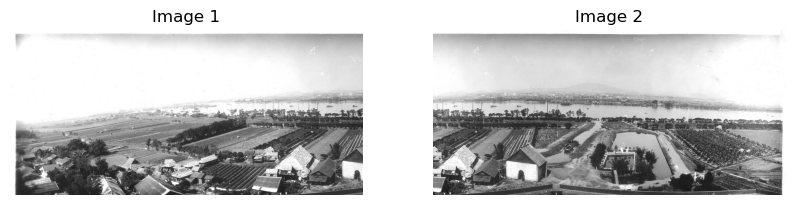

In [6]:
# Convert images from BGR to RGB (Matplotlib expects RGB format)
resized_image_rgb_1 = cv2.cvtColor(image_1, cv2.COLOR_BGR2RGB)
resized_image_rgb_2 = cv2.cvtColor(image_2, cv2.COLOR_BGR2RGB)

# Plot both images side by side
plt.figure(figsize=(10, 5))

# Plot the first image
plt.subplot(1, 2, 1)  # Subplot with 1 row, 2 columns, and position 1
plt.imshow(resized_image_rgb_1)
plt.title('Image 1')
plt.axis('off')  # Turn off axis

# Plot the second image
plt.subplot(1, 2, 2)  # Subplot with 1 row, 2 columns, and position 2
plt.imshow(resized_image_rgb_2)
plt.title('Image 2')
plt.axis('off')  # Turn off axis

plt.show()

In [7]:
pano, non_blend, left_side, right_side, k1, k2, good_matches =ImageStitcher.warp_blend_and_crop_images(image_1, image_2, True)

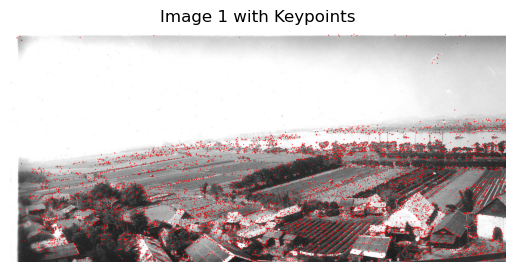

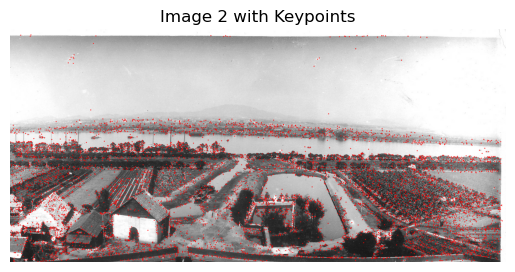

In [8]:
def plot_cv2_keypoints(image, keypoints, title="Image with Keypoints"):
    # Convert cv2.KeyPoint objects to a list of (i, j) coordinates
    keypoints_list = [(int(kp.pt[1]), int(kp.pt[0])) for kp in keypoints]

    # Draw keypoints on the image
    image_with_keypoints = image.copy()
    for i, j in keypoints_list:
        cv2.circle(image_with_keypoints, (j, i), 2, (255, 0, 0), -1)  # Draw a green circle at the keypoint location

    # Display the image with keypoints
    plt.imshow(image_with_keypoints)
    plt.title(title)
    plt.axis('off')  # Turn off axis
    plt.show()

# Plot the keypoints on the image with titles
plot_cv2_keypoints(image_1, k1, title="Image 1 with Keypoints")
plot_cv2_keypoints(image_2, k2, title="Image 2 with Keypoints")

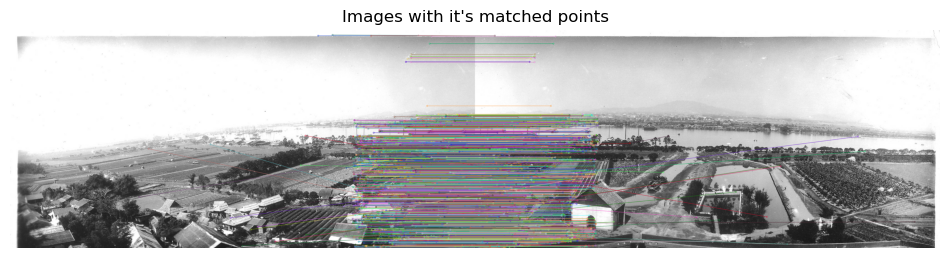

In [9]:
def plot_matches(image1, keypoints1, image2, keypoints2, good_matches, title):
    """Plot good matches between two images"""
    # Draw matches
    matched_image = cv2.drawMatches(
        image1, keypoints1,
        image2, keypoints2,
        good_matches, None,
        flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS
    )
    
    # Plot the matched image
    plt.figure(figsize=(12, 6))
    plt.imshow(matched_image)
    plt.title(title)
    plt.axis('off')
    plt.show()

# Example usage:
# Assuming you have already computed 'good_matches', 'keypoints1', 'keypoints2'
plot_matches(image_1, k1, image_2, k2, good_matches,title = "Images with it's matched points")

In [23]:
def convert_result(img):
    img_normalized = np.array(img, dtype=float) / 255
    img_rgb = img_normalized[:, :, ::-1]
    return img_rgb

Text(0.5, 1.0, 'Left side of panorama before cropping:')

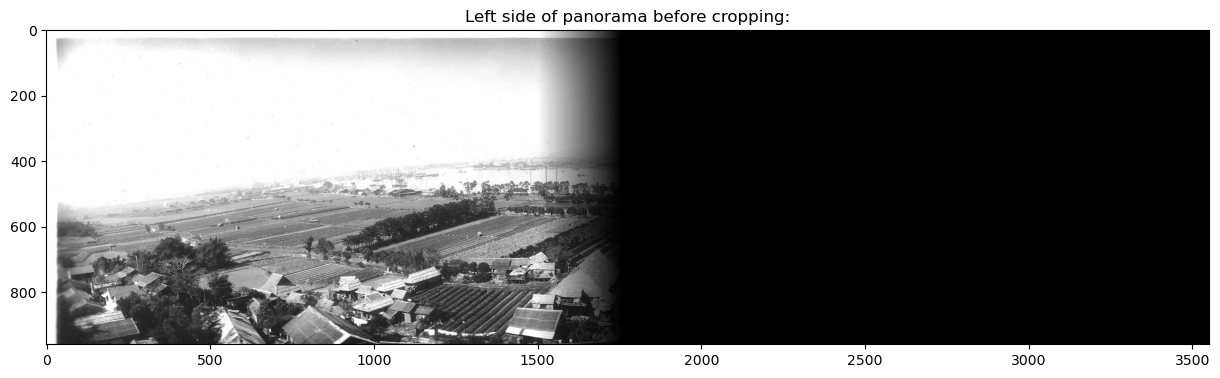

In [11]:
#display the leftside of pano before cropping
plt.figure(figsize=(15,15))
plt.imshow(convert_result(left_side))
plt.title("Left side of panorama before cropping:")

Text(0.5, 1.0, 'Right side of panorama before cropping:')

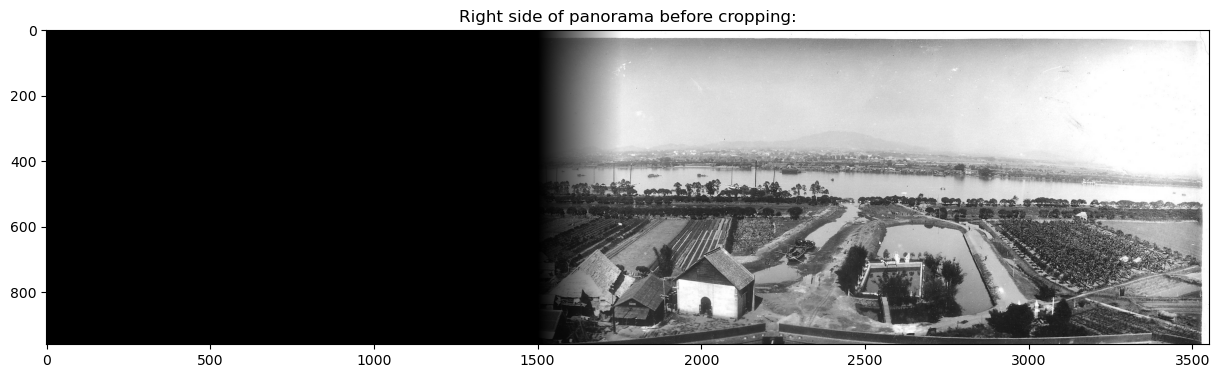

In [24]:
#display the rightside of pano before cropping
plt.figure(figsize=(15,15))
plt.imshow(convert_result(right_side))
plt.title("Right side of panorama before cropping:")

Text(0.5, 1.0, 'Panorama after cropping and blending:')

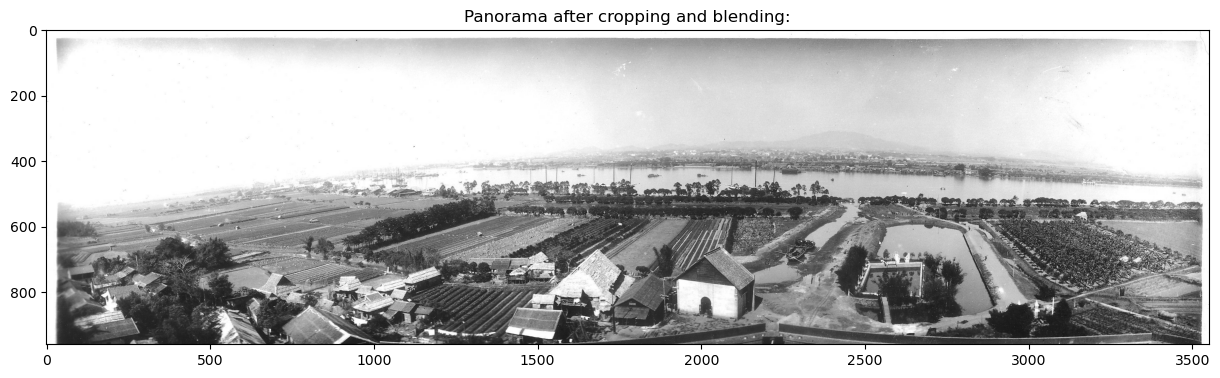

In [14]:
#pano after cropping and blending
plt.figure(figsize=(15,15))
plt.imshow(convert_result(pano))
plt.title("Panorama after cropping and blending:")

# Accuracy Scores

In [15]:
pano.shape

(960, 3551, 3)

In [16]:
full_image = cv2.imread('images-data/Full_image.jpg')

In [17]:
full_image.shape

(960, 3551, 3)

In [18]:
full_image_1 = cv2.resize(full_image, (pano.shape[1], pano.shape[0]), interpolation=cv2.INTER_AREA)

In [19]:
full_image_1.shape

(960, 3551, 3)

In [20]:
def image_similarity(image1, image2):
    """Calculate similarity between two images using Mean Squared Error (MSE) and Structural Similarity Index (SSI)"""
    # Convert images to appropriate depth (8-bit unsigned integers)
    image1 = cv2.convertScaleAbs(image1)
    image2 = cv2.convertScaleAbs(image2)

    # Ensure both images have the same dimensions
    if image1.shape != image2.shape:
        raise ValueError("Input images must have the same dimensions")

    # Convert images to grayscale
    gray_image1 = cv2.cvtColor(image1, cv2.COLOR_BGR2GRAY)
    gray_image2 = cv2.cvtColor(image2, cv2.COLOR_BGR2GRAY)

    # Calculate Mean Squared Error (MSE)
    mse = np.mean((gray_image1.astype(float) - gray_image2.astype(float)) ** 2)

    # Calculate Structural Similarity Index (SSI)
    ssi = ssim(gray_image1, gray_image2)

    return mse, ssi


In [21]:
image_similarity(pano, full_image_1)

(3.0003663874026096, 0.9940841978533885)